In [154]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import pandas as pd
from glob import glob

In [216]:
#** load the dataframe of climatological variables **

# load data from the csv files
csv_files = sorted(glob("./MADIA_daily_dataset_v1.3/csv_data/*_e5_d.csv"))
csv_files = [file for file in csv_files if 1991 <= int(file.split('/')[-1].split('_')[0]) <= 1992]

dailyClimatological_data = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    
    dailyClimatological_data = pd.concat([dailyClimatological_data, df], ignore_index=True)

print(dailyClimatological_data.head())

   longitude  latitude        time     tasmin     tasmax    tasmean     rhmin  \
0      12.25      35.5  1991-01-01  14.007111  15.914581  14.960846  0.800915   
1      12.25      35.5  1991-01-02  14.251373  15.310181  14.780777  0.657868   
2      12.25      35.5  1991-01-03  14.284302  14.663757  14.474030  0.655431   
3      12.25      35.5  1991-01-04  14.027557  15.211334  14.619446  0.676937   
4      12.25      35.5  1991-01-05  13.894623  15.612396  14.753509  0.693268   

      rhmax       ws10       ssrd       ppn       pev  expver  mask  
0  0.893762   5.854601   9.278107  0.018810  1.418778     1.0   1.0  
1  0.851364  10.327004  10.670974  0.036794  2.340696     1.0   1.0  
2  0.674182   5.341772   8.324915  0.000000  2.223704     1.0   1.0  
3  0.854900   5.503022   9.915781  0.008129  1.806671     1.0   1.0  
4  0.839577   7.949931   8.691664  0.330742  2.051346     1.0   1.0  


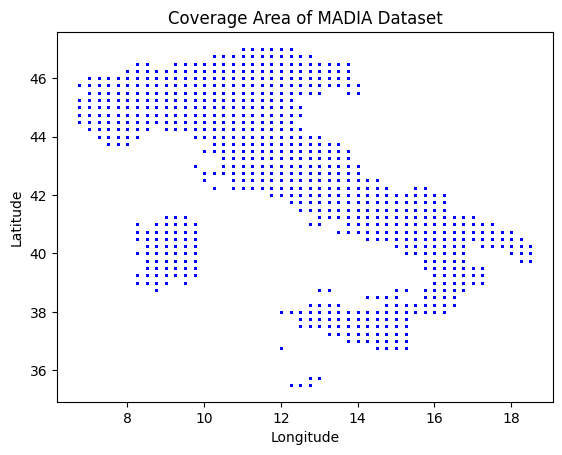

In [217]:
# **show a plot of the coverage area of the MADIA dataset**

plt.scatter(dailyClimatological_data['longitude'], dailyClimatological_data['latitude'], s=1, c='blue', alpha=0.5)
plt.title('Coverage Area of MADIA Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
#** load the dataset of Evapotranspiration from the nc file
nc_files = sorted(glob("./GLEM_daily_dataset/E_*_GLEAM_v4.2a.nc"))

dailyE_data = []

for file in nc_files:
    ds = xr.open_dataset(file)

    # the evapotranspiration data are referenced to the Global territory
    E_lon = ds['lon'].values
    E_lat = ds['lat'].values

    # the climatological data are referenced to the Italian territory
    clim_lon = dailyClimatological_data['longitude'].values
    clim_lat = dailyClimatological_data['latitude'].values

    # select the evapotranspiration data for the Italian territory
    E_lon_idx = np.where((E_lon >= clim_lon.min()) & (E_lon <= clim_lon.max()))
    E_lat_idx = np.where((E_lat >= clim_lat.min()) & (E_lat <= clim_lat.max()))
    E_lon = E_lon[E_lon_idx]
    E_lat = E_lat[E_lat_idx]

    E_data = ds['E'].sel(lon=E_lon, lat=E_lat)
    dailyE_data.append(E_data)

dailyE_data = xr.concat(dailyE_data, dim='time')

/tmp/ipykernel_42810/3907745109.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap


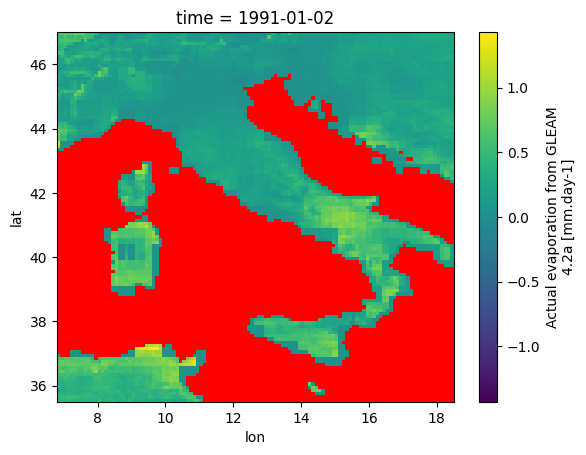

Daily Evapotranspiration shape (time, latitude, longitude): (731, 115, 117)
Number of NaN values in the dataset: 6854


In [ ]:
#** show a plot of the Evapotranspiration data **
et = dailyE_data.isel(time=1)

cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap
cmap.set_bad(color='red')  # highlight NaN values in red

et.plot(cmap=cmap)  # plot the data with the modified colormap

plt.show()

print(f"Daily Evapotranspiration shape (time, latitude, longitude): {dailyE_data.shape}")

# count the number of pixel that are NaN at any time
nan_pixels = np.isnan(dailyE_data).any(dim='time').sum().item()
print(f"Number of NaN values in the dataset: {nan_pixels}")

In [ ]:
#** evaluate the elapsed_days **
dailyClimatological_data['time'] = pd.to_datetime(dailyClimatological_data['time'])
dailyClimatological_data['elapsed_days'] = (dailyClimatological_data['time'] - dailyClimatological_data['time'].min()).dt.days.values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

   longitude  latitude       time     tasmin     tasmax    tasmean     rhmin  \
0      12.25      35.5 1991-01-01  14.007111  15.914581  14.960846  0.800915   
1      12.25      35.5 1991-01-02  14.251373  15.310181  14.780777  0.657868   
2      12.25      35.5 1991-01-03  14.284302  14.663757  14.474030  0.655431   
3      12.25      35.5 1991-01-04  14.027557  15.211334  14.619446  0.676937   
4      12.25      35.5 1991-01-05  13.894623  15.612396  14.753509  0.693268   

      rhmax       ws10       ssrd       ppn       pev  expver  mask  \
0  0.893762   5.854601   9.278107  0.018810  1.418778     1.0   1.0   
1  0.851364  10.327004  10.670974  0.036794  2.340696     1.0   1.0   
2  0.674182   5.341772   8.324915  0.000000  2.223704     1.0   1.0   
3  0.854900   5.503022   9.915781  0.008129  1.806671     1.0   1.0   
4  0.839577   7.949931   8.691664  0.330742  2.051346     1.0   1.0   

   elapsed_days  
0             0  
1             1  
2             2  
3             3  
4 

In [ ]:
#** associate the Evapotranspiration data to the climatological data **

# build a 2D grid of lat/lon points with the evapotranspiration data
grid_lat = dailyE_data['lat'].values
grid_lon = dailyE_data['lon'].values
grid_lon2d, grid_lat2d = np.meshgrid(grid_lon, grid_lat)

from scipy.spatial import cKDTree

# build a KDTree for fast nearest-neighbor search
grid_points = np.column_stack([grid_lat2d.ravel(), grid_lon2d.ravel()])
tree = cKDTree(grid_points)

# extract (lat, lon) from the climate data
query_points = dailyClimatological_data[['latitude', 'longitude']].values

# query the nearest grid points once
_, indices = tree.query(query_points)

# convert flat indices to 2D (lat_idx, lon_idx)
lat_idx, lon_idx = np.unravel_index(indices, grid_lat2d.shape)

# time indices, evaluate the amount of days elapsed since the first day of the dataset
time_idx = dailyClimatological_data['elapsed_days']

# get values from xarray using vectorized indexing
E_values = dailyE_data.isel(
    time=xr.DataArray(time_idx, dims='points'),
    lat=xr.DataArray(lat_idx, dims='points'),
    lon=xr.DataArray(lon_idx, dims='points')
).values

# Assign to DataFrame
dailyClimatological_data['E'] = E_values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

   longitude  latitude       time     tasmin     tasmax    tasmean     rhmin  \
0      12.25      35.5 1991-01-01  14.007111  15.914581  14.960846  0.800915   
1      12.25      35.5 1991-01-02  14.251373  15.310181  14.780777  0.657868   
2      12.25      35.5 1991-01-03  14.284302  14.663757  14.474030  0.655431   
3      12.25      35.5 1991-01-04  14.027557  15.211334  14.619446  0.676937   
4      12.25      35.5 1991-01-05  13.894623  15.612396  14.753509  0.693268   

      rhmax       ws10       ssrd       ppn       pev  expver  mask  \
0  0.893762   5.854601   9.278107  0.018810  1.418778     1.0   1.0   
1  0.851364  10.327004  10.670974  0.036794  2.340696     1.0   1.0   
2  0.674182   5.341772   8.324915  0.000000  2.223704     1.0   1.0   
3  0.854900   5.503022   9.915781  0.008129  1.806671     1.0   1.0   
4  0.839577   7.949931   8.691664  0.330742  2.051346     1.0   1.0   

   elapsed_days   E  
0             0 NaN  
1             1 NaN  
2             2 NaN  
3   

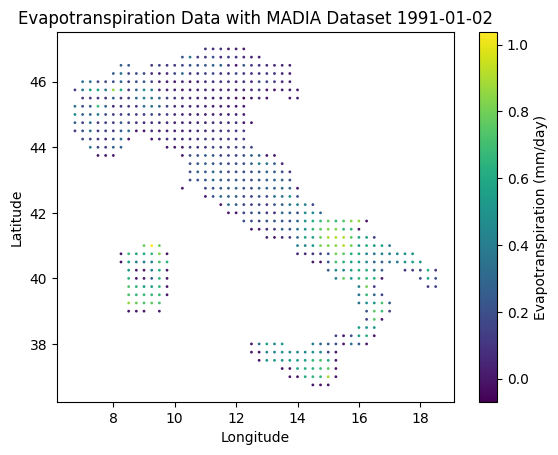

In [230]:
#** show a plot of the Evapotranspiration data with the MADIA dataset **
et = dailyClimatological_data[dailyClimatological_data['elapsed_days'] == 1]
plt.scatter(et['longitude'], et['latitude'], s=1, c=et['E'], cmap='viridis')
plt.colorbar(label='Evapotranspiration (mm/day)')
plt.title(f'Evapotranspiration Data with MADIA Dataset {et["time"].dt.strftime("%Y-%m-%d").values[0]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [238]:
#** print the fields of the dataframe **
print(dailyClimatological_data.columns)

Index(['longitude', 'latitude', 'time', 'tasmin', 'tasmax', 'tasmean', 'rhmin',
       'rhmax', 'ws10', 'ssrd', 'ppn', 'pev', 'expver', 'mask', 'elapsed_days',
       'E'],
      dtype='object')


In [239]:
#** define the features and the target variable **

# features (X) - all meteorological variables and time
# should i use time (the date of the day) or the elapsed days (amount of days since the first day of the dataset) as a feature?
# should i use the ETo (potential evapotranspiration) estimated with the Penman-Monteith equation as a feature?
X = dailyClimatological_data[['longitude', 'latitude', 'elapsed_days', 'tasmin', 'tasmax', 'tasmean', 'rhmin','rhmax', 'ws10', 'ssrd', 'ppn', 'pev']]

print(f"Feature matrix:\n{X.columns}")

# target (y) - ET (evapotranspiration)
y = dailyClimatological_data[['E']]

print(f"Target vector:\n{y.columns}")

Feature matrix:
Index(['longitude', 'latitude', 'elapsed_days', 'tasmin', 'tasmax', 'tasmean',
       'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn', 'pev'],
      dtype='object')
Target vector:
Index(['E'], dtype='object')


In [240]:
from sklearn.preprocessing import StandardScaler

# initialize the scaler
scaler = StandardScaler()

# fit the scaler on the feature set and transform the features
X_scaled = scaler.fit_transform(X)

In [241]:
# if there are any remaining NaN values
X_scaled = pd.DataFrame(X_scaled).dropna().values  # or use fillna() instead of dropna()
y = y.dropna().values  # Drop corresponding rows in y


In [242]:
# X_scaled should already be in the correct shape after scaling
# If X is still in a DataFrame, convert it to a numpy array
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1]))  # (samples, features)


In [243]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [244]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build the NN model
model = models.Sequential()

# Input layer
model.add(layers.Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Output layer (single neuron for regression)
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

2025-05-13 17:18:33.214054: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 17:18:33.222769: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 17:18:33.286872: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 17:18:33.330737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747149513.372892   42810 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747149513.38

Epoch 1/50


/home/cavallinux/Backup/Magistrale/InovativeWirelessPlatform4IoT/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1747149515.089538   42810 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747149515.090084   42810 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


9284/9284 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.3260 - val_loss: 0.2461
Epoch 2/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2482 - val_loss: 0.2439
Epoch 3/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2372 - val_loss: 0.2280
Epoch 4/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2281 - val_loss: 0.2228
Epoch 5/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2221 - val_loss: 0.2165
Epoch 6/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2180 - val_loss: 0.2177
Epoch 7/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2108 - val_loss: 0.2079
Epoch 8/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2064 - val_loss: 0.2029
Epoch 9/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2000 - val_loss: 0.2024
Epoch 10/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.1929 - val_loss: 0.1850
Epoch 11/50
9284/9284 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.1870 - val_loss: 0.1858
Epoch 12/50
9284/9284 ━━━━━━━━

In [245]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Print the test loss
print(f"Test loss: {loss}")

# If you want to also predict the values on the test set
y_pred = model.predict(X_test)


2902/2902 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0942
Test loss: 0.09488549828529358
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step


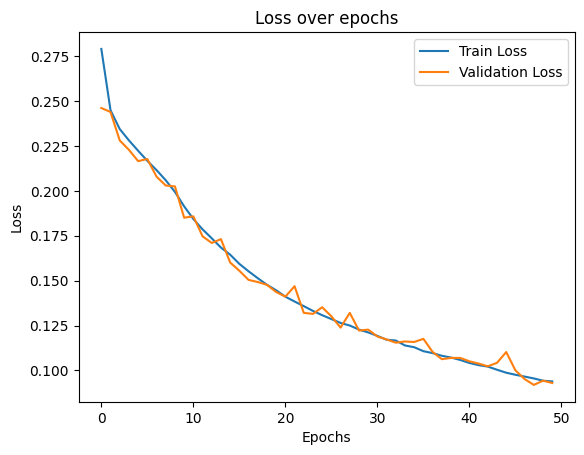

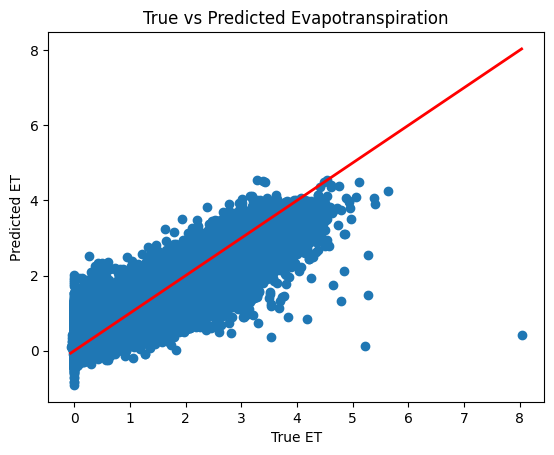

In [246]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted ET
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('True ET')
plt.ylabel('Predicted ET')
plt.title('True vs Predicted Evapotranspiration')
plt.show()